## 基于工具包实现BP网络

### 1、导入包

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from pylab import mpl

### 2、读取数据

In [2]:
def splitdata(datalist):
    inputs_list = []
    targets_list = []
    for record in datalist:
        # 将输入去掉','转化为向量
        all_values=record.split(',')
        # 对数据进行归一化操作转化为0到1间float类型的数字
        inputs=np.asfarray(all_values[1:])/255
        # 定义并初始化标签向量
        targets=np.zeros(10)
        # 将targets数组的第标签个分量的输出置为1，即编码成One-Hot形式
        targets[int(all_values[0])]=1
        inputs_list.append(inputs)
        targets_list.append(targets)
    return np.array(inputs_list), np.array(targets_list)

# 打开训练数据集
train_data_file=open('./mnist_dataset_csv/mnist_train.csv','r')
# 得到数据，一行代表一个输入
train_data_list=train_data_file.readlines()
train_data_file.close()
train_inputs,train_targets = splitdata(train_data_list)

# 打开测试数据集
test_data_file = open('./mnist_dataset_csv/mnist_test.csv', 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
test_inputs,test_targets = splitdata(test_data_list)

### 3、定义神经网络模型

In [3]:
# 定义用于创建神经网络模型的函数
def create_model(num_inputs, hidden_nodes, num_classes):
    model = Sequential()
    # 定义隐藏层单元和输入层神经元，使用normal distribution正态分布来初始化权重(weight)和偏差，激活函数为'sigmoid'
    model.add(Dense(units=hidden_nodes, input_dim=num_inputs, kernel_initializer='normal',  activation='sigmoid'))
    # 定义输出层神经元，神经元个数为标签数，激活函数为‘sigmoid’
    model.add(Dense(units=num_classes, kernel_initializer='normal', activation='sigmoid'))
    # 编译模型
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
    return model

### 4、定义评测函数

In [4]:
# 得分函数，在测试集上进行一次测试
def score(nn, inputs, targets):
    # 通过类方法query输出test数据集中的每一个样本的目标值和预测值进行对比。
    scorecord = []
    outputs = nn.predict(inputs)
    for i in range(outputs.shape[0]):
        # 每个数据的目标值
        correct_label = np.argmax(targets[i])
        # 每个数据的预测值
        label = np.argmax(outputs[i])
        # 预测正确将1加入到scorecord数组，错误加0

        if (label == correct_label):
            scorecord.append(1)
        else:
            scorecord.append(0)
    # 将列表转化为array
    scorecord_array = np.asarray(scorecord)
    # 返回准确率
    return scorecord_array.sum() / scorecord_array.size

### 5、模型训练和测试

In [7]:
# 创建一个神经网络（隐层有50个神经元），并进行训练
model = create_model(train_inputs.shape[1], 50, train_targets.shape[1])
train_scores=[]
test_scores=[]
for e in range(10):
    print('第%d次迭代...'%(e+1))
    model.fit(x=train_inputs, y=train_targets, epochs=1, batch_size=1)
    train_scores.append(score(model,train_inputs,train_targets))
    test_scores.append(score(model,test_inputs,test_targets))
    print('训练准确率：%f'%train_scores[e])
    print('测试准确率：%f'%test_scores[e])

第1次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.955450
测试准确率：0.951300
第2次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.964633
测试准确率：0.960700
第3次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.967933
测试准确率：0.959600
第4次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.974583
测试准确率：0.963000
第5次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.978233
测试准确率：0.965600
第6次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.977100
测试准确率：0.963200
第7次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.978917
测试准确率：0.966200
第8次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.980567
测试准确率：0.966900
第9次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.984283
测试准确率：0.967400
第10次迭代...
313/313 [==============================] - 0s 1ms/step
训练准确率：0.979700
测试准确率：0.960600


### 6、结果的图形化显示

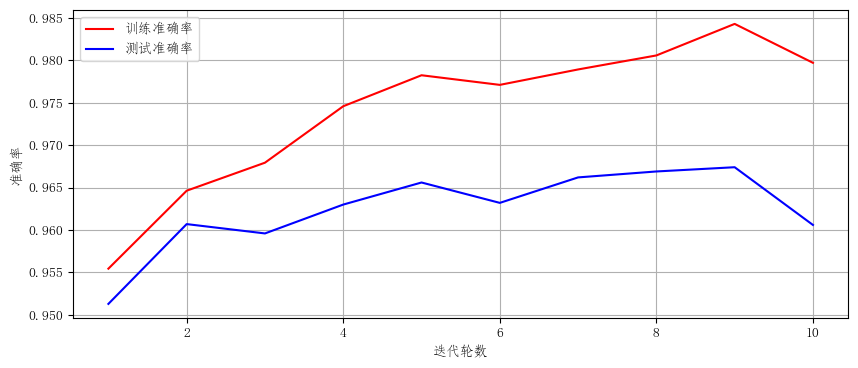

In [9]:
#优化matplotlib汉字显示乱码的问题
mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,4))
plt.xlabel('迭代轮数')  # x轴标签
plt.ylabel('准确率')  # y轴标签
plt.plot(range(1,11),train_scores,c='red',label='训练准确率')
plt.plot(range(1,11),test_scores,c='blue',label='测试准确率')
plt.legend(loc='best')
plt.grid(True)  # 产生网格
plt.show()  # 显示图像

## 自己编程实现BP网络

### 1、导入包

In [10]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from pylab import mpl

### 2、创建神经网络类NeuralNetwork

In [12]:
# 创建神经网络类，以便于实例化成不同的实例
class NeuralNetwork:
    # 初始函数
    def __init__(self, input_nodes,hidden_nodes,output_nodes,learning_rate):
        # 初始化输入层、隐藏层、输出层的节点个数
        self.inodes=input_nodes
        self.hnodes=hidden_nodes
        self.onodes=output_nodes
        # 初始化输入层与隐藏层之间的初始权重参数
        self.wih=np.random.normal(0.0,pow(self.hnodes,-0.5),(self.hnodes,self.inodes))
        # 初始化隐藏层与输出层之间的初始权重参数
        self.who=np.random.normal(0.0,pow(self.hnodes,-0.5),(self.onodes,self.hnodes))
        # 初始化学习率
        self.lr=learning_rate
        # 定义激活函数为sigmoid
        self.activation_function=lambda x: scipy.special.expit(x)
    # 训练函数
    def train(self,input_list,target_list):
        # 将数据的输入和标签转化为列向量
        inputs = np.array(input_list, ndmin=2).T
        targets = np.array(target_list, ndmin=2).T
        # 前向传播过程，隐藏层输入为权重矩阵和输入矩阵做点积
        hidden_inputs = np.dot(self.wih, inputs)
        # 隐藏层接收的输入经激活函数处理得到隐藏层输出，此处未考虑偏置
        hidden_outputs = self.activation_function(hidden_inputs)
        # 同理前向传播得到最终输出层
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        # 预测与实际相减得到偏差矩阵
        output_errors = targets - final_outputs
        # 根据(A.62)计算得到delta
        delta = output_errors * final_outputs * (1 - final_outputs)
        # 根据(A.60)更新隐藏层到输出层的权重矩阵
        self.who += self.lr * np.dot(delta, np.transpose(hidden_outputs))
        # 根据(A.60)和(A.63)更新输入层到隐藏层的权重矩阵
        self.wih += self.lr * np.dot((np.dot(self.who.T, delta) * hidden_outputs * (1 - hidden_outputs)), (np.transpose(inputs)))

    # predict功能，预测新样本的种类
    def predict(self,inputs_list):
        # 转换输入矩阵为列向量
        inputs=np.array(inputs_list,ndmin=2).T
        # 前向传播得到最终输出结果
        hidden_inputs=np.dot(self.wih,inputs)
        hidden_outputs=self.activation_function(hidden_inputs)
        final_inputs=np.dot(self.who,hidden_outputs)
        final_outputs=self.activation_function(final_inputs)
        return final_outputs

    # 得分函数，在测试集上进行一次测试
    def score(self, inputs, targets):
        # 通过类方法query输出test数据集中的每一个样本的目标值和预测值进行对比。
        scorecord = []
        for i in range(len(inputs)):
            # 每个数据的目标值
            correct_label = np.argmax(targets[i])
            # 每个数据的预测值
            outputs = self.predict(inputs[i])
            label = np.argmax(outputs)
            # 预测正确将1加入到scorecord数组，错误加0
            if (label == correct_label):
                scorecord.append(1)
            else:
                scorecord.append(0)
        # 将列表转化为array
        scorecord_array = np.asarray(scorecord)
        # 返回精度
        return scorecord_array.sum() / scorecord_array.size

### 3、神经网络训练和测试

In [13]:
# 手写数字为28*28大小，所以在变成一维数据之后，需要有这么多的输入点，隐藏层神经元可以自行定义；输出层神经元为分类的总个数
input_nodes = 784
hidden_nodes = 50
output_nodes = 10
# 定义学习率
learning_rate = 0.1
# 进行epochs设定
epochs=5

def splitdata(datalist):
    inputs_list = []
    targets_list = []
    for record in datalist:
        # 将输入去掉','转化为向量
        all_values=record.split(',')
        # 对数据进行归一化操作转化为0到1间float类型的数字
        inputs=np.asfarray(all_values[1:])/255
        # 定义并初始化标签向量
        targets=np.zeros(output_nodes)
        # 将targets数组的第标签个分量的输出置为1，即编码成One-Hot形式
        targets[int(all_values[0])]=1
        inputs_list.append(inputs)
        targets_list.append(targets)
    return inputs_list, targets_list

# 打开训练数据集
train_data_file=open('./mnist_dataset_csv/mnist_train.csv','r')
# 得到数据，一行代表一个输入
train_data_list=train_data_file.readlines()
train_data_file.close()
train_inputs,train_targets = splitdata(train_data_list)

# 打开测试数据集
test_data_file = open('./mnist_dataset_csv/mnist_test.csv', 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
test_inputs,test_targets = splitdata(test_data_list)

# 用我们的类创建一个神经网络实例
nn=NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
# 定义分数矩阵，方便后续画图
train_scores=[]
test_scores=[]
for e in range(epochs):
    print('第%d次迭代...'%(e+1))
    # 对每个数据进行一次训练
    for i in range(len(train_inputs)):
        # 训练网络更新权重值
        nn.train(train_inputs[i],train_targets[i])
    # 将分数加到分数数组
    train_scores.append(nn.score(train_inputs,train_targets))
    test_scores.append(nn.score(test_inputs,test_targets))
    print('训练准确率：%f'%train_scores[e])
    print('测试准确率：%f'%test_scores[e])

第1次迭代...
训练准确率：0.931217
测试准确率：0.932400
第2次迭代...
训练准确率：0.950783
测试准确率：0.949200
第3次迭代...
训练准确率：0.960200
测试准确率：0.955800
第4次迭代...
训练准确率：0.965500
测试准确率：0.960200
第5次迭代...
训练准确率：0.969417
测试准确率：0.961900


### 4、结果的图形化展示

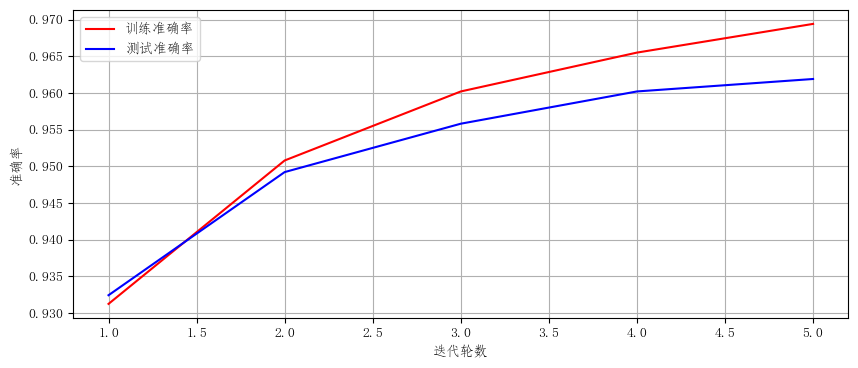

In [14]:
#优化matplotlib汉字显示乱码的问题
mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,4))
plt.xlabel('迭代轮数')  # x轴标签
plt.ylabel('准确率')  # y轴标签
plt.plot(range(1,6),train_scores,c='red',label='训练准确率')
plt.plot(range(1,6),test_scores,c='blue',label='测试准确率')
plt.legend(loc='best')
plt.grid(True)  # 产生网格
plt.show()  # 显示图像